# Librerias

In [1]:
import os
import sys
root_dir = os.path.abspath(os.path.join(os.path.dirname('./pruebillas.ipynb'), '..'))
os.chdir(root_dir)

sys.path.insert(0, os.path.join(root_dir, 'src'))

In [5]:
from backtesting import Strategy
import pandas as pd
import talib as ta
import pandas_ta as pandas_ta
from datetime import datetime
import itertools
import MetaTrader5 as mt5
import pytz
from utils import walk_forward, plot_full_equity_curve
import numpy as np
import random
random.seed(42)

In [7]:
list(np.arange(2, 15, 1))

[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]

# Obtener datos

In [3]:
# establish connection to the MetaTrader 5 terminal
if not mt5.initialize():
    print("initialize() failed, error code =",mt5.last_error())
    quit()
 
# get all symbols
symbols = mt5.symbols_get()


groups = []
for symbol in symbols:
    group = symbol.path.split('\\')[0]
    if not group in groups:
        groups.append(group)
groups


['Forex_Indicator',
 'CryptoCross_grp',
 'Crypto_group',
 'Energies_group',
 'Forex_group',
 'Indices_group',
 'Stocks_group']

In [4]:

tickers = [symbol.path.split('\\')[1] for symbol in symbols if 'Stocks_group' in symbol.path and symbol.spread < 15]
print(tickers)

['AAPLm', 'ABBVm', 'ABTm', 'AMZNm', 'ATVIm', 'AVGOm', 'BACm', 'BMYm', 'CMCSAm', 'CSCOm', 'CSXm', 'CVSm', 'EAm', 'EBAYm', 'GILDm', 'INTCm', 'JNJm', 'JPMm', 'KOm', 'MDLZm', 'MMMm', 'MOm', 'MRKm', 'MSm', 'NKEm', 'ORCLm', 'PEPm', 'PFEm', 'PGm', 'PMm', 'PYPLm', 'SBUXm', 'Tm', 'TSLAm', 'UPSm', 'VZm', 'WMTm', 'XOMm', 'AMCm', 'BBm', 'BBBYm', 'BEKEm', 'BILIm', 'BRQSm', 'BYNDm', 'CANm', 'FTNTm', 'IQm', 'JDm', 'LIm', 'NIOm', 'NTESm', 'RLXm', 'TIGRm', 'TMEm', 'TSMm', 'VIPSm', 'XPEVm', 'YUMCm', 'ZTOm']


In [5]:
intervals = [
    mt5.TIMEFRAME_H4,
]

parameter_combinations = list(itertools.product(
    tickers, intervals
))

symbols = {}

print("MetaTrader5 package author: ", mt5.__author__)
print("MetaTrader5 package version: ", mt5.__version__)

# Establecer conexión con el terminal de MetaTrader 5
if not mt5.initialize():
    raise Exception("initialize() failed, error code =", mt5.last_error())

# Establecer la zona horaria a UTC
timezone = pytz.timezone("Etc/UTC")

# Crear objetos 'datetime' en zona horaria UTC
utc_from = datetime(2010, 10, 1, tzinfo=timezone)
utc_to = datetime(2024, 9, 1, tzinfo=timezone)

for ticker, interval in parameter_combinations:
    print(ticker)
    # Obtener las tasas históricas
    rates = mt5.copy_rates_range(ticker, interval, utc_from, utc_to)
    
    # Crear DataFrame con las tasas
    df = pd.DataFrame(rates)
    
    # Convertir el tiempo de segundos a formato datetime
    df['time'] = pd.to_datetime(df['time'], unit='s')


    # Renombrar columnas para el ticker principal
    df = df.rename(columns={
        'time': 'Date',
        'open': 'Open',
        'high': 'High',
        'low': 'Low',
        'close': 'Close',
        'tick_volume': 'Volume'
    }).set_index('Date')


    df.index = df.index.tz_localize('UTC').tz_convert('UTC')
    
    utc_to_ts = pd.Timestamp(utc_to).tz_convert('UTC')

    days = (utc_to_ts - df.index[-1]).days
    if days >= 4:
        tickers.remove(ticker)
        print(f'se descarto {ticker}')
        continue

    if ticker not in symbols.keys():
        symbols[ticker] = {}
        symbols[ticker][interval] = {}

    symbols[ticker][interval] = df


# Cerrar la conexión con MetaTrader 5
mt5.shutdown()



MetaTrader5 package author:  MetaQuotes Ltd.
MetaTrader5 package version:  5.0.4288
AAPLm
ABBVm
ABTm
AMZNm
ATVIm
se descarto ATVIm
AVGOm
BACm
BMYm
CMCSAm
CSCOm
CSXm
CVSm
EAm
EBAYm
GILDm
INTCm
JNJm
JPMm
KOm
MDLZm
MMMm
MOm
MRKm
MSm
NKEm
ORCLm
PEPm
PFEm
PGm
PMm
PYPLm
SBUXm
Tm
TSLAm
UPSm
VZm
WMTm
XOMm
AMCm
se descarto AMCm
BBm
BBBYm
se descarto BBBYm
BEKEm
BILIm
BRQSm
se descarto BRQSm
BYNDm
se descarto BYNDm
CANm
se descarto CANm
FTNTm
IQm
JDm
LIm
NIOm
NTESm
RLXm
TIGRm
se descarto TIGRm
TMEm
TSMm
VIPSm
XPEVm
YUMCm
ZTOm


True

In [6]:
max_start_date = None
intervals_start_dates = {}

for interval in intervals:
    for ticker in tickers:
        if not max_start_date or symbols[ticker][interval].index.min() > max_start_date:
            max_start_date = symbols[ticker][interval].index.min()
        
    intervals_start_dates[interval] = max_start_date

intervals_start_dates

{16388: Timestamp('2021-10-27 16:00:00+0000', tz='UTC')}

# WFO

In [7]:
class DayPerWeek(Strategy):
    risk=1
    day_to_buy = 3
    percentage_price_sl = 5
    sma_period = 200
    rsi_period = 2
    rsi_upper_threshold = 90
    
    def init(self):
        self.sma = self.I(
            ta.SMA, self.data.Close, timeperiod=self.sma_period
        )

        self.rsi = self.I(
            ta.RSI, self.data.Close, 2
        )
        
    def next(self):
        
        today = self.data.index[-1]

        if self.position:
            first_trade = self.trades[0]
            time_in_position = (today - first_trade.entry_time)
            time_in_position = time_in_position.days

            if self.position.is_long:
                if self.rsi > self.rsi_upper_threshold:
                    self.position.close()

        else:
                                                                
            # es el dia de compra, el precio esta por encima de la sma
            if today.day_of_week == self.day_to_buy and self.data.Close[-1] > self.sma[-1]:
                
                sl_price = self.data.Close[-1] - self.data.Close[-1] *  (self.percentage_price_sl / 100)
                
                self.buy(
                    size=self.risk/100,
                    sl=sl_price
                )

In [8]:

import numpy as np
from sklearn.linear_model import LinearRegression

def optim_func_2(stats):
    equity_curve = stats._equity_curve['Equity'].values    
    x = np.arange(len(equity_curve)).reshape(-1, 1)
    reg = LinearRegression().fit(x, equity_curve)
    stability_ratio = reg.score(x, equity_curve)
    
    return (stats['Return [%]'] /  (1 + (-1*stats['Max. Drawdown [%]']))) * np.log(1 + stats['# Trades']) * stability_ratio
    

In [9]:
stats_per_symbol = {}

strategy = DayPerWeek

wfo_performance = pd.DataFrame()
for ticker, intervals in symbols.items():
    for interval in intervals:
        print(ticker, interval)
        
        lookback_bars = 1000
        validation_bars = 250
        warmup_bars = 200

        params = {
            'day_to_buy': list(np.arange(0, 5, 1)),
            'percentage_price_sl': list(np.arange(2, 15, 2)),
            'maximize': optim_func_2
        }

        try:
            wfo_stats = walk_forward(
                strategy,
                symbols[ticker][interval], 
                lookback_bars=lookback_bars,
                validation_bars=validation_bars,
                warmup_bars=warmup_bars, 
                params=params,
                commission=7e-4, 
                margin=1/30, 
                cash=100_000,
                verbose=False
            )
            
            stats_per_symbol[ticker] = {}
            stats_per_symbol[ticker][interval] = wfo_stats
            
            df_equity = wfo_stats['_equity']
            
            plot_full_equity_curve(df_equity, title=f'{ticker}, {interval}')        
            
            # Calculo el stability ratio
            x = np.arange(df_equity.shape[0]).reshape(-1, 1)
            reg = LinearRegression().fit(x, df_equity.Equity)
            stability_ratio = reg.score(x, df_equity.Equity)
            

            # Extraigo metricas
            df_stats = pd.DataFrame({
                'strategy':[strategy.__name__],
                'ticker':[ticker],
                'interval':[interval],
                'stability_ratio':[stability_ratio],
                'return':[wfo_stats['Return [%]']],
                'final_eq':[wfo_stats['Equity Final [$]']],
                'drawdown':[wfo_stats['Max. Drawdown [%]']],
                'drawdown_duration':[wfo_stats['Max. Drawdown Duration']],
                'win_rate':[wfo_stats['Win Rate [%]']], 
                'sharpe_ratio':[wfo_stats['Sharpe Ratio']],
                'trades':[wfo_stats['# Trades']],
                'avg_trade_percent':[wfo_stats['Avg. Trade [%]']],
                'exposure':[wfo_stats['Exposure Time [%]']],
                'final_equity':[wfo_stats['Equity Final [$]']],
                'Duration':[wfo_stats['Duration']],

            })

            wfo_performance = pd.concat([wfo_performance, df_stats])
        
        except:
            print(f'No se pudo ejecutar para el ticker {ticker}')

wfo_performance['return/dd'] = wfo_performance['return'] / -wfo_performance['drawdown']
wfo_performance['drawdown'] = -wfo_performance['drawdown']
wfo_performance['custom_metric'] = (wfo_performance['return'] / (1 + wfo_performance.drawdown)) * np.log(1 + wfo_performance.trades)

wfo_performance.drawdown_duration = pd.to_timedelta(wfo_performance.drawdown_duration)
wfo_performance.drawdown_duration = wfo_performance.drawdown_duration.dt.days

wfo_performance.sort_values(by='return/dd', ascending=False)

AAPLm 16388


ABBVm 16388


ABTm 16388


AMZNm 16388


AVGOm 16388


BACm 16388


BMYm 16388


CMCSAm 16388


CSCOm 16388


CSXm 16388


CVSm 16388


EAm 16388


EBAYm 16388


GILDm 16388


INTCm 16388


JNJm 16388


JPMm 16388


KOm 16388


MDLZm 16388


MMMm 16388


MOm 16388


MRKm 16388


MSm 16388


NKEm 16388


ORCLm 16388


PEPm 16388


PFEm 16388


PGm 16388


PMm 16388


PYPLm 16388


SBUXm 16388


Tm 16388


TSLAm 16388


UPSm 16388


VZm 16388


WMTm 16388


XOMm 16388


BBm 16388


BEKEm 16388


BILIm 16388


FTNTm 16388


IQm 16388


JDm 16388


LIm 16388


NIOm 16388


NTESm 16388


RLXm 16388


TMEm 16388


TSMm 16388


VIPSm 16388


XPEVm 16388


YUMCm 16388


ZTOm 16388


,strategy,ticker,interval,stability_ratio,return,final_eq,drawdown,drawdown_duration,win_rate,sharpe_ratio,trades,avg_trade_percent,exposure,final_equity,Duration,return/dd,custom_metric
0,EndOfMonth,WMTm,16388,0.860799,2.443976,102162.456847,0.508346,169,70.000000,4.086815,20,0.352266,7.921382,102162.456847,1038 days,4.807707,4.933048
0,EndOfMonth,AMZNm,16388,0.895557,13.124735,112280.647218,2.865882,141,79.746835,1.624133,79,0.473757,12.839816,112280.647218,1038 days,4.579650,14.877057
0,EndOfMonth,CSXm,16388,0.905381,2.755665,102430.235405,0.767870,176,81.250000,2.622013,16,0.493542,8.457415,102430.235405,1038 days,3.588711,4.416266
0,EndOfMonth,ABBVm,16388,0.888649,2.199173,101526.482430,0.647825,171,68.421053,2.006146,19,0.262200,10.720667,101526.482430,1038 days,3.394704,3.998079
0,EndOfMonth,JPMm,16388,0.782267,3.177542,103306.863111,1.316891,164,81.818182,3.391735,22,0.490726,7.325789,103306.863111,1038 days,2.412912,4.300230
0,EndOfMonth,LIm,16388,0.430089,7.291174,107100.615675,3.594514,245,43.478261,0.900732,69,0.300016,7.530648,107100.615675,1038 days,2.028417,6.742067
0,EndOfMonth,VZm,16388,0.699683,2.152701,103500.471718,1.199186,210,70.000000,1.367440,20,0.560679,6.730197,103500.471718,1038 days,1.795135,2.980169
0,EndOfMonth,TSMm,16388,0.712836,6.587949,106955.091762,4.347758,200,65.454545,0.803756,55,0.380091,12.116113,106955.091762,1038 days,1.515252,4.958866
0,EndOfMonth,GILDm,16388,0.739474,1.742676,101898.963749,1.167525,169,71.428571,1.823095,14,0.439382,7.087552,101898.963749,1038 days,1.492624,2.177254
0,EndOfMonth,BACm,16388,0.681151,4.915528,105070.835841,3.740675,273,64.814815,0.765599,54,0.287673,10.004221,105070.835841,1038 days,1.314075,4.155138


In [16]:
filtered_wfo_performance = wfo_performance[
    (wfo_performance.stability_ratio > 0.7)
    & (wfo_performance['return/dd'] > 2)
]
filtered_wfo_performance

,strategy,ticker,interval,stability_ratio,return,final_eq,drawdown,drawdown_duration,win_rate,sharpe_ratio,trades,avg_trade_percent,exposure,final_equity,Duration,return/dd,custom_metric
0,EndOfMonth,ABBVm,16388,0.888649,2.199173,101526.482430,0.647825,171,68.421053,2.006146,19,0.262200,10.720667,101526.482430,1038 days,3.394704,3.998079
0,EndOfMonth,AMZNm,16388,0.895557,13.124735,112280.647218,2.865882,141,79.746835,1.624133,79,0.473757,12.839816,112280.647218,1038 days,4.579650,14.877057
0,EndOfMonth,CSXm,16388,0.905381,2.755665,102430.235405,0.767870,176,81.250000,2.622013,16,0.493542,8.457415,102430.235405,1038 days,3.588711,4.416266
0,EndOfMonth,JPMm,16388,0.782267,3.177542,103306.863111,1.316891,164,81.818182,3.391735,22,0.490726,7.325789,103306.863111,1038 days,2.412912,4.300230
0,EndOfMonth,WMTm,16388,0.860799,2.443976,102162.456847,0.508346,169,70.000000,4.086815,20,0.352266,7.921382,102162.456847,1038 days,4.807707,4.933048


# Montecarlo

In [11]:
from utils import montecarlo_statistics_simulation

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Crear una lista para almacenar los resultados de cada ticker
data_drawdown = []
data_return = []

dd_df = pd.DataFrame()
ret_df = pd.DataFrame()

for ticker in filtered_wfo_performance.ticker.tolist():
    print(f"Procesando ticker: {ticker}")
    trades_history = stats_per_symbol[ticker][16388]._trades
    
    # Simulación de Montecarlo para cada ticker (datos agregados)
    mc, dd, ret = montecarlo_statistics_simulation(trade_history=trades_history, n_simulations=100_000, initial_equity=100_000, threshold_ruin=0.8, return_raw_curves=True)
    
    display(mc)
    
    dd['ticker'] = ticker
    ret['ticker'] = ticker
    
    dd_df = pd.concat([dd_df, dd])
    ret_df = pd.concat([ret_df, ret])



Procesando ticker: ABBVm


,Drawdown (%),Final Return (%)
count,100000.000000,100000.000000
mean,-3.249498,5.226418
std,1.721905,5.322404
min,-15.600225,-16.709253
25%,-4.107830,1.591795
50%,-2.883037,5.127721
75%,-2.010012,8.728333
max,0.000000,28.695297
Risk of Ruin,0.000000,NaN


Procesando ticker: AMZNm


,Drawdown (%),Final Return (%)
count,100000.000000,100000.000000
mean,-10.743347,47.941660
std,4.141616,28.381128
min,-41.319259,-38.201163
25%,-12.848991,27.882408
50%,-9.954892,45.276630
75%,-7.766401,65.074759
max,-2.203186,231.768667
Risk of Ruin,0.006420,NaN


Procesando ticker: CSXm


,Drawdown (%),Final Return (%)
count,100000.000000,100000.000000
mean,-3.242372,8.379495
std,1.810645,6.489002
min,-20.319181,-18.584622
25%,-4.140232,3.899419
50%,-2.875300,8.192558
75%,-1.963643,12.640922
max,0.000000,38.050461
Risk of Ruin,0.000000,NaN


Procesando ticker: JPMm


,Drawdown (%),Final Return (%)
count,100000.000000,100000.000000
mean,-2.098002,11.473166
std,1.084858,5.362412
min,-13.275074,-11.763723
25%,-2.634114,7.791745
50%,-1.893335,11.362508
75%,-1.339310,15.023008
max,0.000000,36.309082
Risk of Ruin,0.000000,NaN


Procesando ticker: WMTm


,Drawdown (%),Final Return (%)
count,100000.000000,100000.000000
mean,-3.017637,7.413778
std,1.585224,5.668061
min,-14.946417,-14.694175
25%,-3.803368,3.527890
50%,-2.685117,7.287751
75%,-1.892454,11.138331
max,0.000000,33.802937
Risk of Ruin,0.000000,NaN


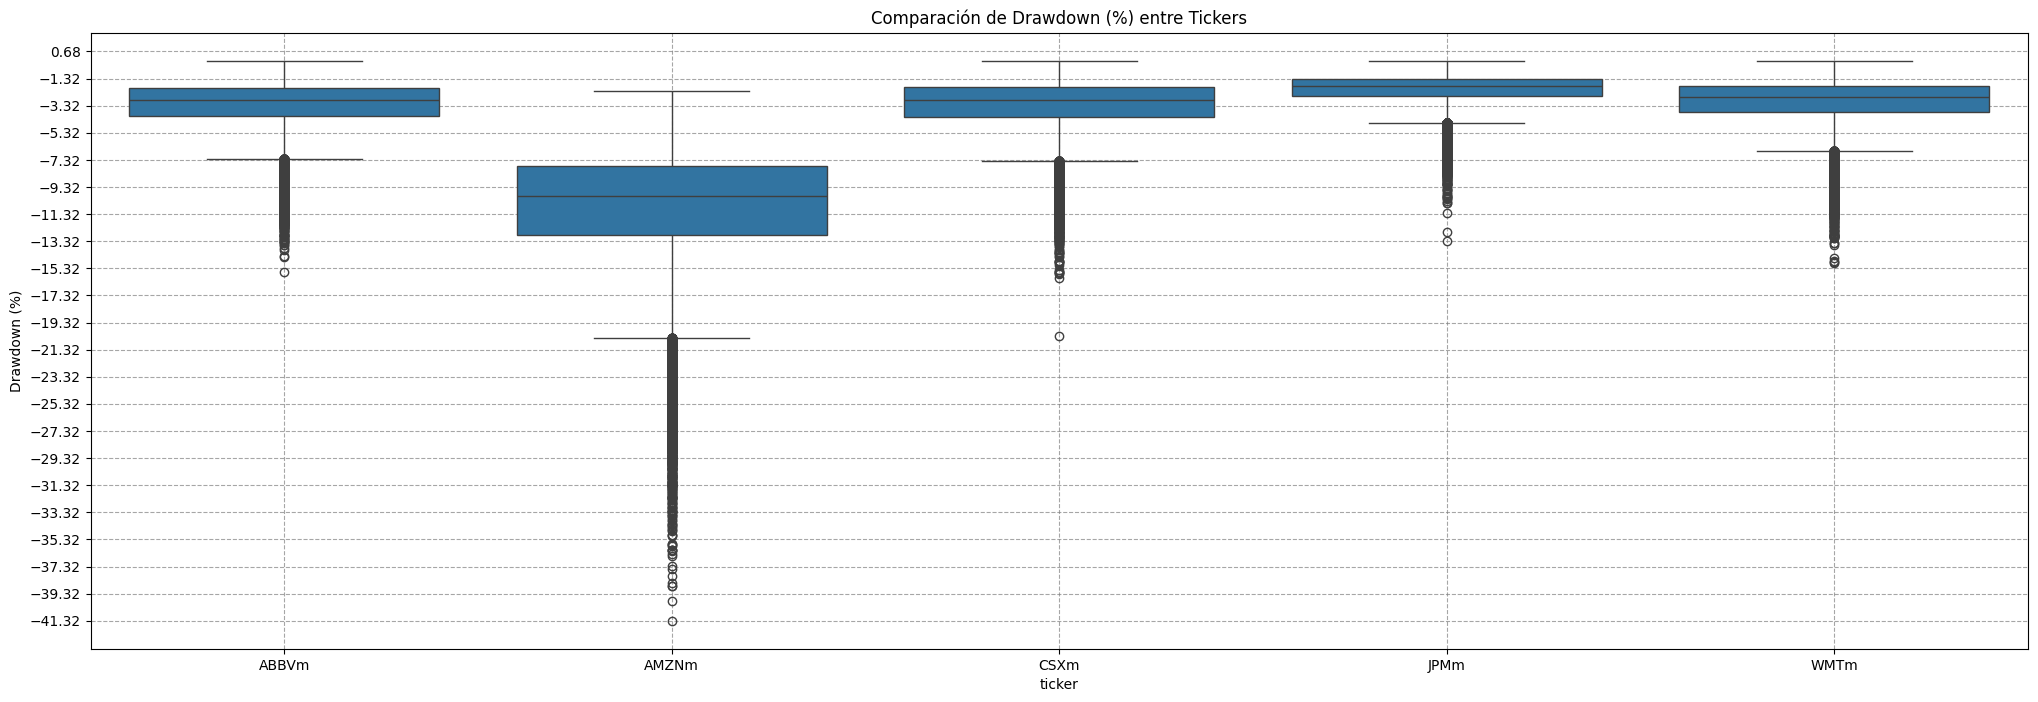

In [13]:
# Configurar el gráfico con matplotlib y seaborn
plt.figure(figsize=(25, 8))
sns.boxplot(data=dd_df, x="ticker", y="Drawdown (%)")
plt.title("Comparación de Drawdown (%) entre Tickers")

y_max = dd_df["Drawdown (%)"].max()  # Valor máximo en el eje Y
y_min = dd_df["Drawdown (%)"].min()  # Valor mínimo en el eje Y
tick_interval = 2  # Intervalo deseado entre números en el eje Y

# Configurar los ticks mayores en el eje Y
plt.yticks(np.arange(y_min, y_max + tick_interval, tick_interval))

# Activar la cuadrícula
plt.grid(True, linestyle='--', which='both', color='grey', alpha=0.7)

# Mostrar el gráfico
plt.show()

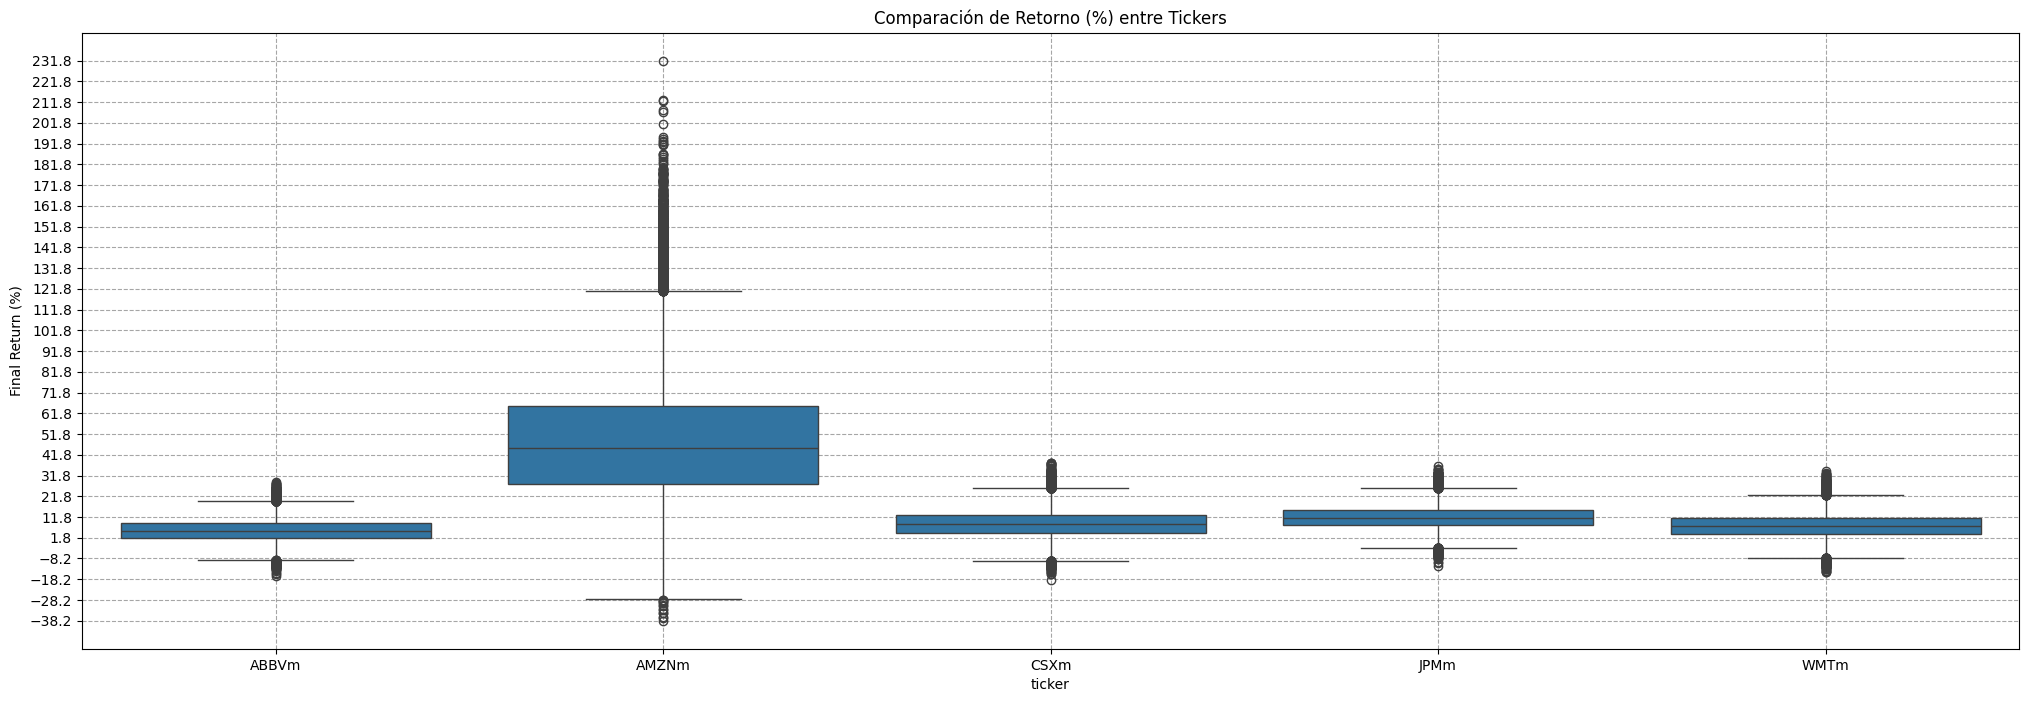

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Generar el gráfico
plt.figure(figsize=(25, 8))
sns.boxplot(data=ret_df, x="ticker", y="Final Return (%)")
plt.title("Comparación de Retorno (%) entre Tickers")

# Configurar ticks mayores con más números
y_max = ret_df["Final Return (%)"].max()  # Valor máximo en el eje Y
y_min = ret_df["Final Return (%)"].min()  # Valor mínimo en el eje Y
tick_interval = 10  # Intervalo deseado entre números en el eje Y

# Configurar los ticks mayores en el eje Y
plt.yticks(np.arange(y_min, y_max + tick_interval, tick_interval))

# Activar la cuadrícula
plt.grid(True, linestyle='--', which='both', color='grey', alpha=0.7)

# Mostrar el gráfico
plt.show()


In [15]:
    def max_drawdown(equity_curve):
        running_max = np.maximum.accumulate(equity_curve)
        drawdown = (equity_curve - running_max) / running_max
        return np.min(drawdown) * 100  # Convertir el drawdown a porcentaje
    
    max_drawdown([10])

0.0